In [1]:
import pystan as stan
from scipy.special import logit, expit
from numpy.random import normal, choice, binomial, uniform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#ckmr_model = stan.CmdStanModel(stan_file='~/src/ckmr/src/sib.stan')
ckmr_model_full = stan.StanModel(file='/home/alex/src/ckmr/src/sib_full.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_38295530529c69c6df6c90ece89f7fea NOW.


In [3]:
df = pd.read_excel('PIRU_mykiss_parentage.xlsx')
df = df[df['Count'] > 0]
df = df[['Count']]

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [3]:
def preprocess_data(df):
    df = df[['OffspringID', 'MotherID', 'FatherID']]
    df = df.groupby(['MotherID', 'FatherID'], as_index=False).count()
    df = df.rename(columns={'OffspringID': 'Count'})
    df = df[df['Count'] > 0]
    return df
    
def sub_sample(df, p=0.1):
    tot = df['Count'].sum()
    new_count = binomial(df['Count'], p)
    df1 = df[set(df.columns).difference({'Count'})]
    df1['Count'] = new_count
    df1 = df1[df1['Count'] > 0]
    return df1
    

def make_stan_data(df, method='normal', osr=[0.0, 0.01], prom=[-2.5, 0.11]):
    if method == 'normal':
        method = 1
    elif method == 'beta':
        method = 2
    else:
        raise ValueError(f'Invalid method: {method}')
    data = {
        'method': method,
        'osr_mu': osr[0],
        'osr_sigma': osr[1],
        'G': len(df['Count']),
        'M': df['FatherID'].nunique(),
        'F': df['MotherID'].nunique(),
        'N': df['Count'].sum(),
        'grp_size': df['Count'].values
    }
    return data

def plot_results(dfs, field='F0', ci=0.99, title='', label='', ax=None):
    dfs = summarize_samples(dfs, ci=ci, field=field)
    ns = [d[0] for d in dfs]
    summaries = [d[1] for d in dfs]
    if ax is None:
        _, ax = plt.subplots(figsize=(16, 9))
    y0 = [s[field].loc['mean'] for s in summaries]
    y1 = [s[field].iloc[4] for s in summaries]
    y2 = [s[field].iloc[6] for s in summaries]
    ax.plot(ns, y0, 'o-', label=f'{label} mean')
    ax.fill_between(ns, y1, y2, alpha=0.5, label=f'{label} {(100*ci):.1f}% CI')
    ax.set_xlabel('sample size')
    ax.set_ylabel(f'{field} estimate')
    ax.set_title(title)
    return ax
    
def sample_data(dfs, method='normal', osr=[0.0, 0.01], **kwargs):
    fits = [(d['Count'].sum(), ckmr_model_full.sampling(data=make_stan_data(d, method=method, osr=osr), **kwargs)) for d in dfs]
    fits.sort(key=(lambda x: x[0]))
    return fits

def summarize_samples(fits, ci=0.99, field='F0'):
    lower = 0.5 * (1.0 - ci)
    upper = 1.0 - lower
    quants = (lower, upper)
    res = [(n, d.to_dataframe(pars=[field]).describe(percentiles=quants)) for (n, d) in fits]
    return res
    
def make_synth_data(M0, F0, G0, N):
    N0 = M0 + F0
    gs = choice(M0*F0, size=G0, replace=False)
    gs = np.array([[g // F0, g % F0] for g in gs], dtype=int).T
    xs = choice(G0, size=N)
    df = pd.DataFrame(data={'OffspringID': np.arange(N), 'FatherID': gs[0, xs], 'MotherID': gs[1, xs]})
    return df

In [5]:
dfs = (sub_sample(df, p=p) for p in np.arange(0.05, 1.0, 0.05))
fits = sample_data(dfs, chains=4, show_progress=False, iter_sampling=2000)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 

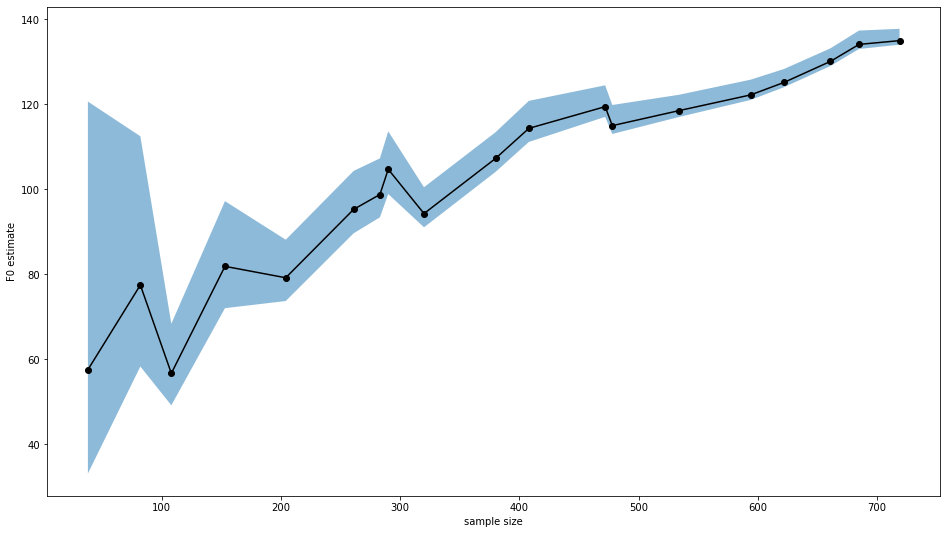

In [6]:
plot_results(fits, field='F0')

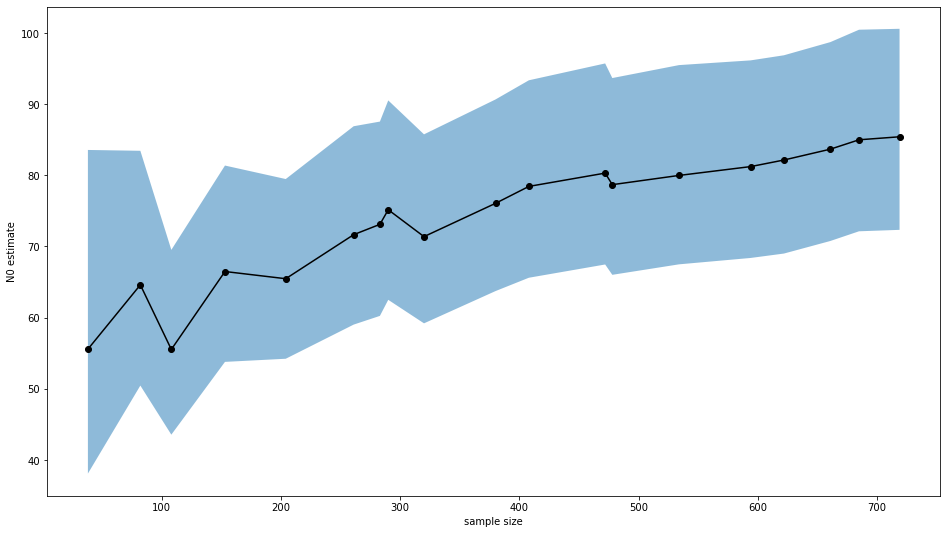

In [7]:
plot_results(fits, field='N0')

In [8]:
dfs1 = (make_synth_data(137, N) for N in range(100, 1000, 100))
fits1 = sample_data(dfs1, chains=4, show_progress=False, iter_sampling=2000)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 

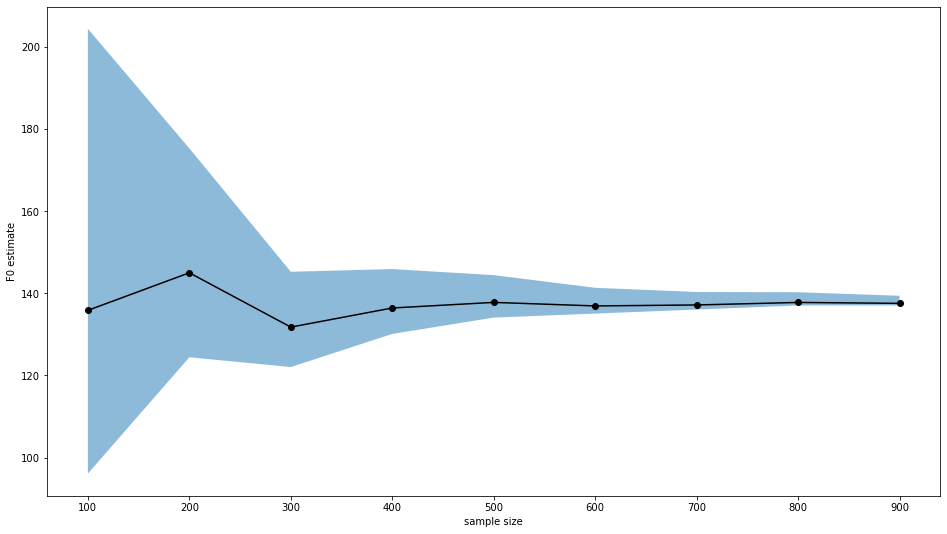

In [9]:
plot_results(fits1, field='F0')

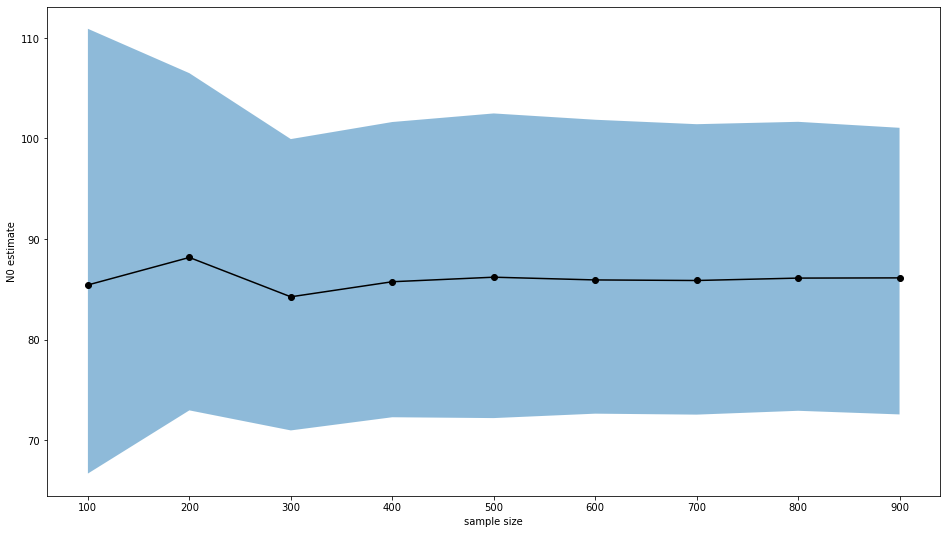

In [10]:
plot_results(fits1, field='N0')

In [4]:
dfs2 = (make_synth_data(1234, N) for N in range(200, 2200, 200))
fits2 = sample_data(dfs2, chains=4, show_progress=False, iter_sampling=2000)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 

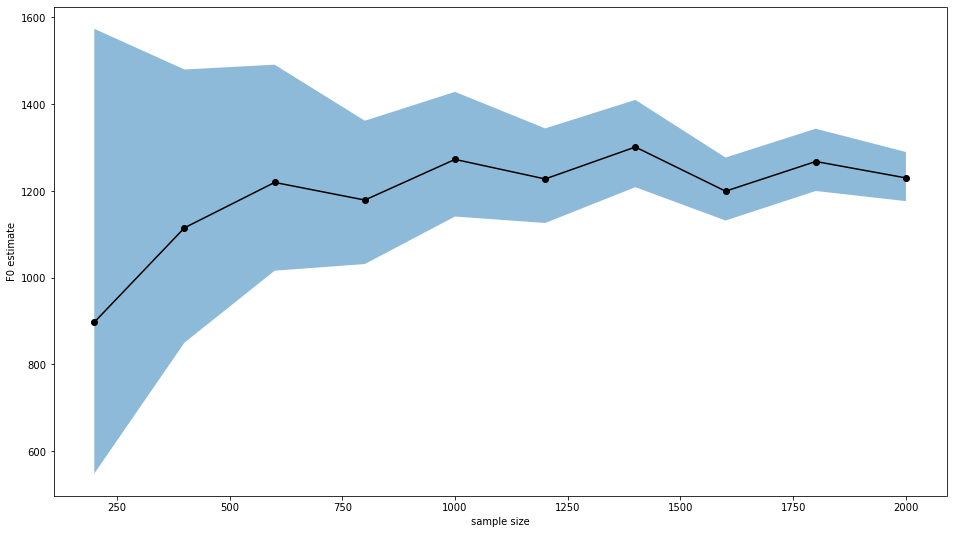

In [5]:
plot_results(fits2, field='F0')

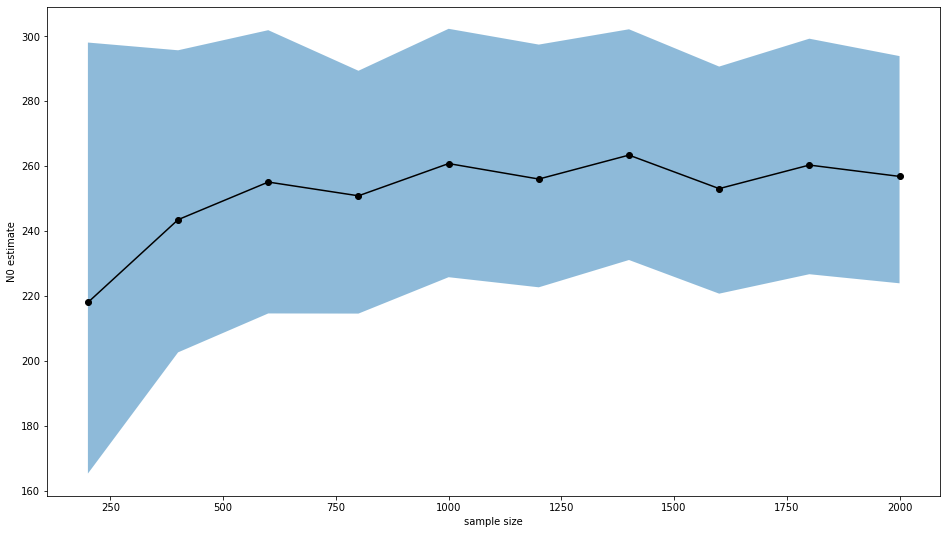

In [6]:
plot_results(fits2, field='N0')

In [10]:
df3 = preprocess_data(pd.read_csv('/home/alex/src/ckmr/Stan_mykiss_2021_Run1.BestConfig'))

In [11]:
df3

,MotherID,FatherID,Count
0,1,1,1
1,2,2,1
2,3,3,2
3,4,4,1
4,5,5,1
...,...,...,...
125,126,126,2
126,127,127,1
127,128,128,1
128,129,129,1


In [34]:
dfs3 = [sub_sample(df3, p=p) for p in np.linspace(0.2, 1.0, 18)]
norm3 = sample_data(dfs3, method='normal', chains=4, iter=2000)
beta3 = sample_data(dfs3, method='beta', chains=4, iter=2000)

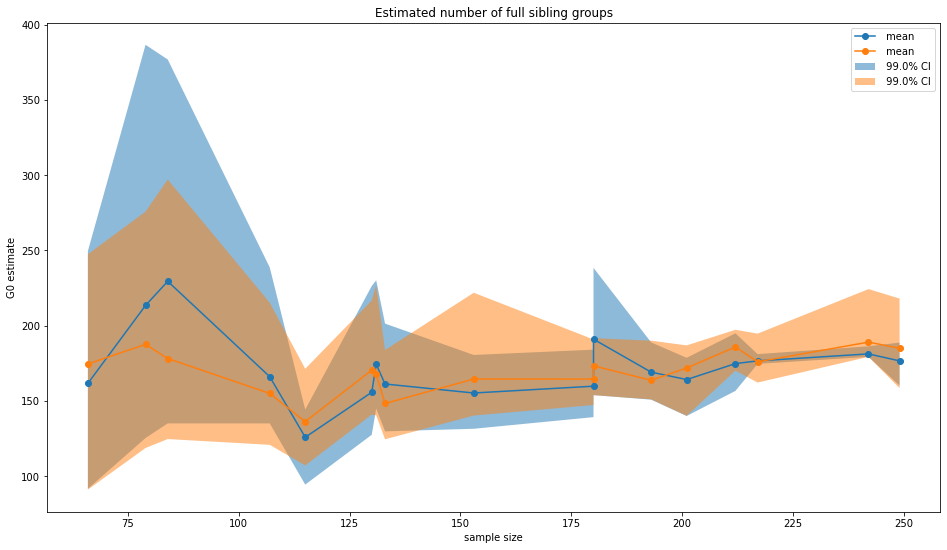

In [35]:
ax = plot_results(norm3[1:], field='G0', title='Estimated number of full sibling groups')
ax = plot_results(beta3[1:], field='G0', title='Estimated number of full sibling groups', ax=ax)
ax.legend()

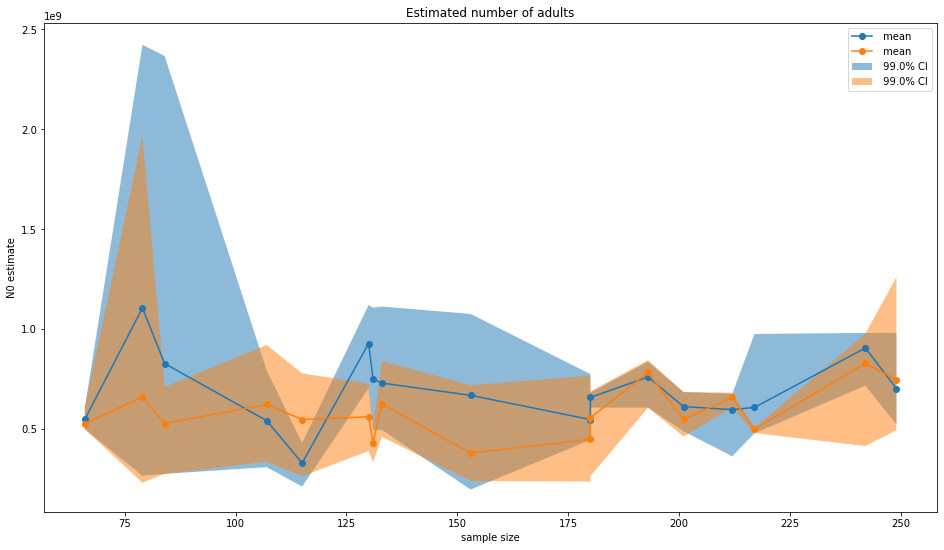

In [36]:
ax = plot_results(norm3[1:], field='N0', title='Estimated number of adults')
ax = plot_results(beta3[1:], field='N0', title='Estimated number of adults', ax=ax)
ax.legend()

In [37]:
norm3[-1][1].to_dataframe(pars=['G0', 'N0', 'M0', 'F0', 'osr']).describe(percentiles=[0.005, 0.995])[['G0', 'N0', 'M0', 'F0', 'osr']]

,G0,N0,M0,F0,osr
count,4000.000000,4.000000e+03,4.000000e+03,4.000000e+03,4000.000000
mean,176.525555,7.011500e+08,3.506082e+08,3.505419e+08,0.500068
std,9.086073,1.674238e+08,8.366279e+07,8.379356e+07,0.002180
min,160.118128,5.208475e+08,2.584160e+08,2.586474e+08,0.492931
0.5%,160.130798,5.209070e+08,2.591499e+08,2.594299e+08,0.493911
50%,181.200561,6.595890e+08,3.276225e+08,3.278374e+08,0.500383
99.5%,188.680910,9.793688e+08,4.913124e+08,4.890927e+08,0.505440
max,190.739698,9.845438e+08,4.936073e+08,4.937187e+08,0.506803


In [38]:
beta3[-1][1].to_dataframe(pars=['G0', 'N0', 'M0', 'F0', 'osr']).describe(percentiles=[0.005, 0.995])[['G0', 'N0', 'M0', 'F0', 'osr']]

,G0,N0,M0,F0,osr
count,4000.000000,4.000000e+03,4.000000e+03,4.000000e+03,4000.000000
mean,184.910555,7.452352e+08,3.728754e+08,3.723599e+08,0.500210
std,20.677914,3.012693e+08,1.508815e+08,1.504151e+08,0.003015
min,145.060482,4.926770e+08,2.430914e+08,2.450719e+08,0.493297
0.5%,158.449316,4.927332e+08,2.436308e+08,2.455000e+08,0.493712
50%,184.293143,6.229691e+08,3.121001e+08,3.101761e+08,0.500657
99.5%,217.940531,1.258653e+09,6.306949e+08,6.321243e+08,0.508662
max,218.902467,1.265525e+09,6.324581e+08,6.355100e+08,0.509424


In [39]:
print(beta3[-1][1].stansummary())

Inference for Stan model: anon_model_38295530529c69c6df6c90ece89f7fea.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%     25%    50%    75%  97.5%  n_eff   Rhat
osr_logit  8.4e-4  3.7e-3   0.01  -0.02 -7.7e-3 2.6e-3 9.3e-3   0.02     10    1.5
N0          7.5e8   2.1e8  3.0e8  4.9e8   5.1e8  6.2e8  1.0e9  1.3e9      2 108.36
M0          3.7e8   1.1e8  1.5e8  2.4e8   2.5e8  3.1e8  5.0e8  6.3e8      2   81.0
G0         184.91   13.44  20.68 158.54  165.35 184.29 207.59 217.17      2   3.32
osr           0.5  9.4e-4 3.0e-3   0.49     0.5    0.5    0.5   0.51     10    1.5
F0          3.7e8   1.1e8  1.5e8  2.5e8   2.5e8  3.1e8  5.0e8  6.3e8      2   78.1
theta[1]   5.5e-3  3.7e-4 6.0e-4 4.6e-3  4.8e-3 5.4e-3 6.1e-3 6.3e-3      3   2.81
theta[2]   5.5e-3  3.7e-4 6.0e-4 4.6e-3  4.8e-3 5.4e-3 6.1e-3 6.3e-3      3   2.81
theta[3]   5.5e-3  3.7e-4 6.0e-4 4.6e-3  4.8e-3 5.4e-3 6.1e-3 6.

In [44]:
plt.scatter(norm3[-1][1].draws_pd(['F0'])['F0'], norm3[-1][1].draws_pd(['M0'])['M0'], alpha=0.3, label='normal')
plt.scatter(beta3[-1][1].draws_pd(['F0'])['F0'], beta3[-1][1].draws_pd(['M0'])['M0'], alpha=0.3, label='beta')
plt.xlabel('females')
plt.ylabel('males')
plt.legend()

AttributeError: 'stanfit4anon_model_725269e3c9ddbc44a3a0bd3bfd28fb0' object has no attribute 'draws_pd'

In [32]:
beta3[-1][1].diagnose()

INFO:cmdstanpy:Processing csv files: /run/user/1000/tmpjiguiiwb/sib_full-202109232035-1-dfi1bmw5.csv, /run/user/1000/tmpjiguiiwb/sib_full-202109232035-2-vdx2wix1.csv, /run/user/1000/tmpjiguiiwb/sib_full-202109232035-3-z339lglk.csv, /run/user/1000/tmpjiguiiwb/sib_full-202109232035-4-5l9swl0l.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


'Processing csv files: /run/user/1000/tmpjiguiiwb/sib_full-202109232035-1-dfi1bmw5.csv, /run/user/1000/tmpjiguiiwb/sib_full-202109232035-2-vdx2wix1.csv, /run/user/1000/tmpjiguiiwb/sib_full-202109232035-3-z339lglk.csv, /run/user/1000/tmpjiguiiwb/sib_full-202109232035-4-5l9swl0l.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.'

In [74]:
df4 = preprocess_data(pd.read_csv('/home/alex/src/ckmr/Piru_mykiss-Run1.BestConfig.txt'))

In [80]:
dfs4 = [sub_sample(df4, p=p) for p in np.linspace(0.1, 1.0, 19)]
norm4 = sample_data(dfs4, method='normal', osr=[0.0, 10.0], chains=4, iter=2000)
beta4 = sample_data(dfs4, method='beta', osr=[0.0, 10.0], chains=4, iter=2000)

KeyboardInterrupt: 

In [ ]:
ax = plot_results(norm4, field='G0', title='Estimated number of full sibling groups')
ax = plot_results(beta4, field='G0', title='Estimated number of full sibling groups', ax=ax)
ax.legend()

In [ ]:
ax = plot_results(norm4, field='N0', title='Estimated number of adults')
ax = plot_results(beta4, field='N0', title='Estimated number of adults', ax=ax)
ax.legend()

In [ ]:
norm4[-1][1].to_dataframe(['G0', 'N0', 'M0', 'F0', 'osr']).describe(percentiles=[0.005, 0.995])

In [ ]:
beta4[-1][1].to_dataframe(['G0', 'N0', 'M0', 'F0', 'osr']).describe(percentiles=[0.005, 0.995])

In [60]:
df5 = preprocess_data(make_synth_data(149, 152, 1743, 500))
dfs5 = [sub_sample(df5, p=p) for p in np.linspace(0.05, 1.0, 20)]
norm5 = sample_data(dfs5, method='normal', osr=[0.0, 0.1], chains=4, iter=2000)
beta5 = sample_data(dfs5, method='beta', osr=[0.0, 0.1], chains=4, iter=2000)

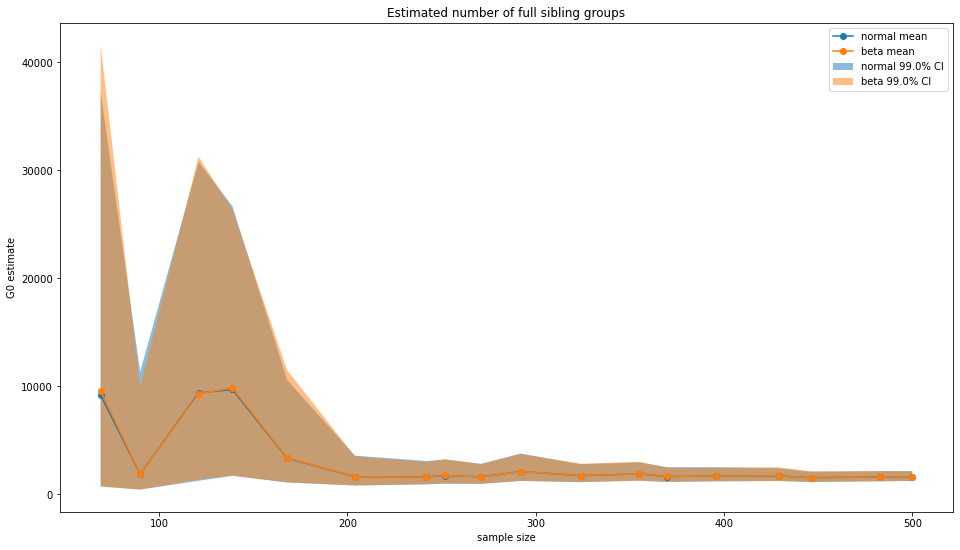

In [67]:
ax = plot_results(norm5[2:], field='G0', title='Estimated number of full sibling groups', label='normal')
ax = plot_results(beta5[2:], field='G0', title='Estimated number of full sibling groups', label='beta', ax=ax)
ax.legend()

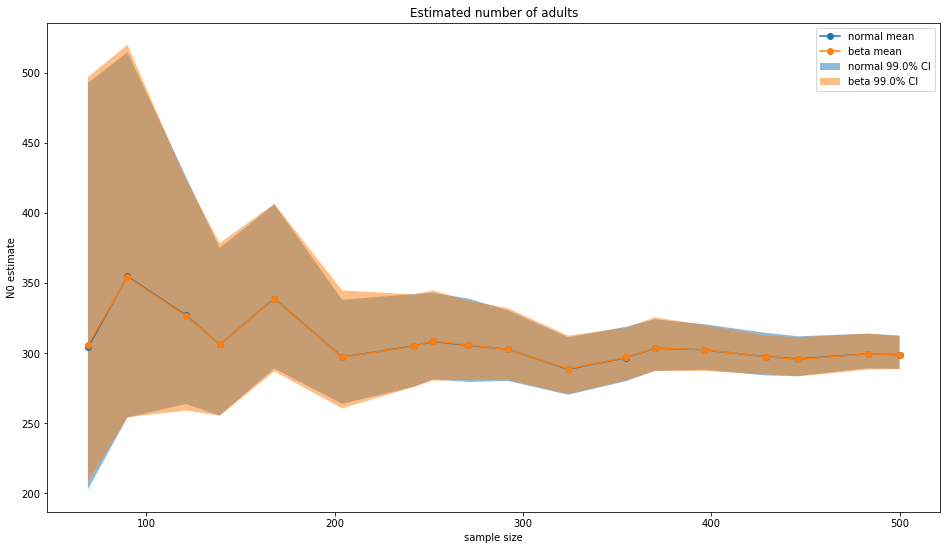

In [66]:
ax = plot_results(norm5[2:], field='N0', title='Estimated number of adults', label='normal')
ax = plot_results(beta5[2:], field='N0', title='Estimated number of adults', label='beta', ax=ax)
ax.legend()

In [68]:
beta5[-1][1].to_dataframe(pars=['G0', 'N0', 'M0', 'F0', 'osr']).describe(percentiles=[0.005, 0.995])[['G0', 'N0', 'M0', 'F0', 'osr']]

,G0,N0,M0,F0,osr
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,1628.103810,298.749586,148.168069,150.581517,0.498534
std,176.404702,4.581805,3.144971,3.216367,0.018808
min,1111.188393,285.395711,140.264903,142.228274,0.432964
0.5%,1237.512902,288.443747,141.425204,143.703717,0.449219
50%,1616.523238,298.477582,147.957353,150.295931,0.498606
99.5%,2142.275887,311.970550,157.712902,159.952953,0.547709
max,2439.774267,321.471644,163.069499,165.645421,0.572681


In [64]:
df5

,MotherID,FatherID,Count
0,0,36,2
1,0,76,1
2,0,104,1
3,0,120,1
4,1,60,1
...,...,...,...
424,150,121,1
425,150,130,1
426,151,31,1
427,151,47,2


In [65]:
df5.nunique()

MotherID    142
FatherID    140
Count         3
dtype: int64